# Dynamic Time Warping for Speech Recognition
<h4><center><em>Adrien Boitreaud & Clara Teissier </em></center></h4>
Chloé Clavel / Matthieu Labeau (original lab by Olivier Cappé)

In [466]:
import os, wave
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn import utils

In [467]:
# Set your own path here
# path is the relative path to the directory that contains SIG, SIG2, and SIGMIX
path = 'Data DTW/'

## Data

The directory ```DATA``` contains three directories :
- ```SIG``` contains 12 repetitions of numbers from 0 to 9 by speaker1 (F e = 8000kHz). SIG_Rep_5_Number_3.wav is the recording corresponding to the fifth repetition of the number “3” . The first four repetitions of each number are represented on Figure 1.
- ```SIG2```, contains 6 repetitions of numbers from 0 to 9 by speaker2
- ```SIG_MIXED``` contains 6 repetitions of the number by speaker1 (SIG_MIXED_Rep_1:6) and then by speaker2 ( SIG_MIXED_Rep_7:12).

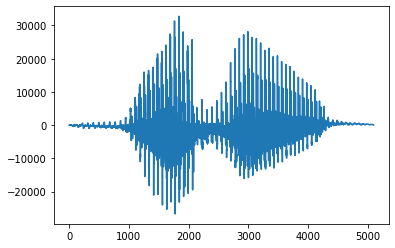

In [468]:
from scipy.io import wavfile

file_path = path +"SIG/SIG_Rep_1_Number_0.wav"
sample_rate, wav_data = wavfile.read(file_path)
plt.plot(wav_data)
plt.show()

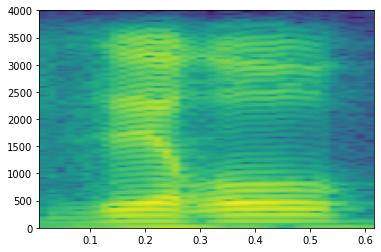

In [469]:
plt.specgram(wav_data, Fs=sample_rate)
plt.show()

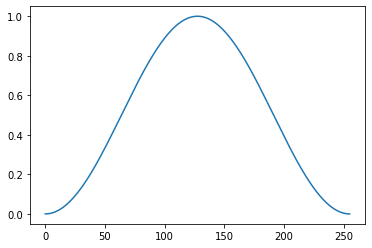

In [470]:
plt.plot(np.hanning(256))
plt.show()

## Speech Feature Extraction

Write a python function ```feature_extraction``` to calculate the cepstral parameterization associated with each pronunciation. With regard to the parameters of the analysis, we will make the following choices: 
- **Parameterization type**: Cepstrum (real number) using linear frequency scale (as opposed to Mel-frequency cepstrum) and computed using FFT (Fast Fourier Transform)
- **Weigthing window**: Hanning

The inputs of the function will be the following:
- **Wav data**: The data extracted from a .wav file
- **Window size**: 256 samples (32 ms)
- **Window shift**: 128 samples
- **Cepstral order**: p = 10


For each signal, the result of the analysis is a sequence of parameters that will be stored in a matrix
according to the following convention:

$$ \quad X = \underbrace{\left[\begin{array}{c} 
 X_1 \\
 X_2 \\
 \vdots \\
 X_{l_X}
\end{array} \right]}_p  $$

Each $X_i$ is a line vector of size $p$. Note that the number of ceptral vectors obtained ($l_X$) depends on the length of the signal, so it is variable. We obtain one matrix of this type per signal.

In [471]:
def feature_extraction(wav_data, window_size, window_shift, cepstral_order):
    #
    # Indication: use the numpy functions np.hanning, np.fft.fft, and np.fft.ifft.
    # Use the attribute .real to take the real part of complex numbers that are output by np.fft.ifft
    # Don't hesitate to look at the numpy documentation to get a better understanding of what the functions do !
    nb_windows = wav_data.size//window_shift
    cepstral_vectors = []
    for i in range(nb_windows-1):
        x = wav_data[i*window_shift: i*window_shift + window_size]
        spectrum = np.fft.fft(x*np.hanning(window_size))
        log_spec = np.log(np.abs(spectrum))
        cepstral_vectors.append(np.real(np.fft.ifft(log_spec))[:cepstral_order])
    return cepstral_vectors

In [472]:
# Example !
window_size = 256
window_shift = 128
cepstral_order = 10
cepstral_vectors = feature_extraction(wav_data, window_size, window_shift, cepstral_order)

In [473]:
print("Shape of cepstral matrix:", [len(cepstral_vectors), len(cepstral_vectors[0])])

Shape of cepstral matrix: [38, 10]


## Time Alignment by Dynamic Programming

Write a python function ```time_alignment(x, y, gamma)``` performing time alignment by dynamic programming between two sequences of vectors stored with the convention above. The Euclidean norm between the following vectors and time
constraints will be used:

\begin{matrix}
  \bullet & \rightarrow & \bullet\\
   & \nearrow_{\gamma} & \uparrow\\
  \bullet & & \bullet
\end{matrix}

with a diagonal weighting $\gamma$ that may be chosen different from 1. It is essential to carry out this function in a parameterized way in order to be able to validate it on the mono-dimensional example being studied.
The function will take as **inputs** the two vector sequences $(X_1, \dots, X_{l_X})$ et $(Y_1, \dots, Y_{l_Y})$ stored in the two matrices, as well as the parameter $\gamma$. It will then execute the following operations:
- **Calculation of the similarity matrix**: Given the two vector sequences, calculate the matrix $D (l_X \times l_Y)$ such that $D(i,j) = \|X_i-Y_j\|$.
- **Initialization of the cumulative distance matrix**: Calculate the content of the first row and column of the cumulative distance matrix $C (l_X \times l_Y)$ such that $C(i,j)$ contains the cumulative distance along the minimum cumulative distance path joining the node $(i,j)$ at the initial node $(1,1)$.
- **Calculation of the matrix of cumulative distances**: For $i$ ranging from 2 to $\min(l_X,l_Y)$, calculation of $C(i,i)$ then $C(i+1,i), \dots C(l_X,i)$ and $C(i,i+1), C(i,i+2), \dots C(i,l_Y)$ (you will recall what justifies this way to proceed). To store the predecessor along the optimal path leading to $(i,j)$, you can use a three-dimensional array $B (l_X \times l_Y \times 2)$ since the predecessor is a node of the network defined by its two coordinates (we can alternatively use a "code" representing the three possible predecessors).
- ***Bactracking***: From the node $(l_X,l_Y)$, reconstruction of the optimal path (starting from the end).

Finally, the **output** will be the cumulative distance along the path of least cost  (```distance```) and the alignment path (```M```), in the form of the matrix  $M$  with two columns such that $X_{M(i,1)}$  is the vector mapped to $Y_{M(i,2)}$ (note that the number of lines in this matrix corresponding to the length of the optimal path is variable). The function can also return the matrix of cumulative distances (```C```).

In [474]:
from scipy.spatial.distance import cdist

def time_alignment(x, y, gamma):
    sim_matrix = cdist(np.array(x), np.array(y), 'euclidean')
    
    # Initialization of the cumulative distance matrix 
    C = np.zeros_like(sim_matrix)
    for i in range(C.shape[0]):
        s = 0
        for k in range(i):
            s += sim_matrix[k,0]
        C[i,0] = s
    for j in range(C.shape[1]):
        s = 0
        for k in range(j):
            s += sim_matrix[0,k]
        C[0,j] = s
    
    # Calculation of the matrix of cumulative distances:
    n, m = C.shape
    pred = np.zeros((n,m,2), dtype = int)
    norm_factor = 0
    for i in range(1, C.shape[0]):
        for j in range(1, C.shape[1]):
            v = C[i-1, j] + sim_matrix[i,j] # vertical
            h = C[i, j-1] + sim_matrix[i,j] # horizontal
            d = C[i-1, j-1] + gamma*sim_matrix[i,j] # diagonal
            m  = min(h,v,d)
            if m == v:
                pred[i,j] = [i-1, j]
            elif m == h:
                pred[i,j] = [i, j-1]
            else:
                assert m==d
                pred[i,j] = [i-1, j-1]
            C[i,j] = m
    # backtracking
    M = [[i,j]]
    loc = (i,j)
    while  (i,j) !=  (0,0):
        if i - pred[i,j][0] :
            if j -pred[i,j][1] :
                norm_factor += gamma
            else : norm_factor += 1
        else : norm_factor += 1
        i, j = pred[i,j][0], pred[i,j][1] # update i,j with its predecessor
        M.append([i,j])
    distance = C[-1,-1]      
    return C, M, distance/norm_factor

In [475]:
# Example of time alignment
file_path_1 = path + "/SIG/SIG_Rep_1_Number_0.wav"
sample_rate_1, wav_data_1 = wavfile.read(file_path_1)
file_path_2 = path + "/SIG/SIG_Rep_2_Number_0.wav"
sample_rate_2, wav_data_2 = wavfile.read(file_path_2)
cepstral_vectors_1 = feature_extraction(
wav_data_1, window_size, window_shift, cepstral_order)
cepstral_vectors_2 = feature_extraction(
wav_data_2, window_size, window_shift, cepstral_order)

np.set_printoptions(precision=4)
C, M, distance = time_alignment(cepstral_vectors_1, cepstral_vectors_2, gamma=2)

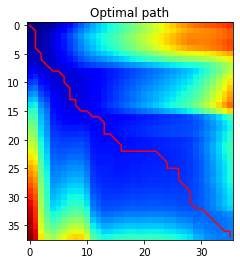

Cost of the optimal path: 0.3281745715530288


In [476]:
# Example of visualization of the optimal path
M = np.array(M)
plt.imshow(C, cmap='jet')
plt.title("Optimal path")
plt.plot(M[:,1], M[:,0], color='red')
plt.show()
print("Cost of the optimal path:", distance)

## Applications to Speech Data

First, working on the data from ```SIG```, you will align a reference sequence (for example, the one corresponding to the first repetition of the first word) with all the others. If we try to find, among all numbers of a given repetition (from 1 to 12), which is the same one as the reference, by looking at the closest in terms of distance (of the path of least cost):
1. Are the performances satisfactory ?
2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
3. What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?

In [477]:
def clean_title(str):
    return str.replace("SIG_",'').replace(".wav","")

In [478]:
path_sig = path + 'SIG/'
file_list = os.listdir(path_sig)
ref = path_sig + file_list[0]
sample_rate_ref, wav_data_ref = wavfile.read(ref)
cepstral_vectors_ref = feature_extraction(wav_data_ref, window_size, 
                                          window_shift, cepstral_order)

Ref is Data DTW/SIG/Rep_10_Number_0


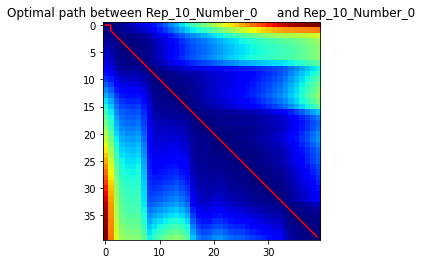

For Rep_10_Number_0, cost of the optimal path: 0.0


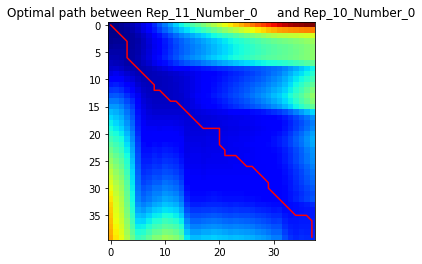

For Rep_11_Number_0, cost of the optimal path: 0.311817940351801


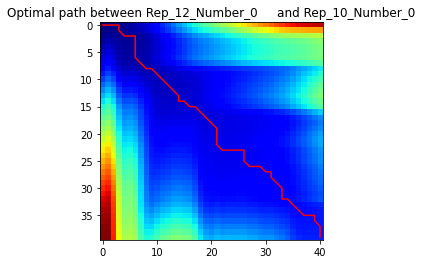

For Rep_12_Number_0, cost of the optimal path: 0.30687231253567854


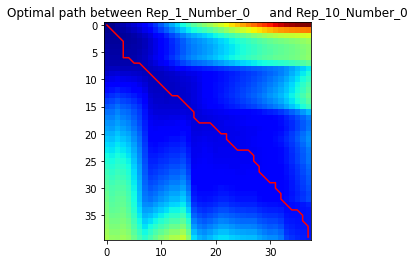

For Rep_1_Number_0, cost of the optimal path: 0.2956462513671776


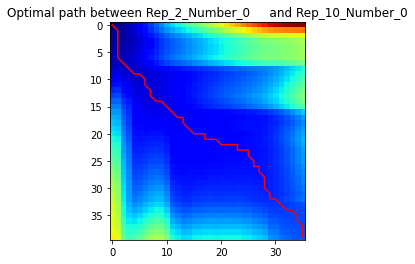

For Rep_2_Number_0, cost of the optimal path: 0.41553531313151465


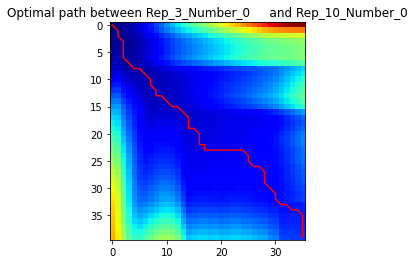

For Rep_3_Number_0, cost of the optimal path: 0.35362031456693993


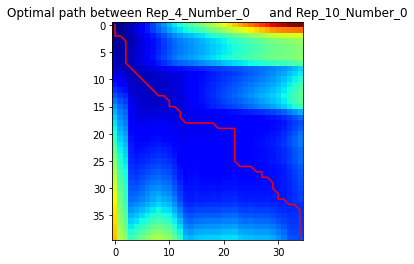

For Rep_4_Number_0, cost of the optimal path: 0.39560465423368096


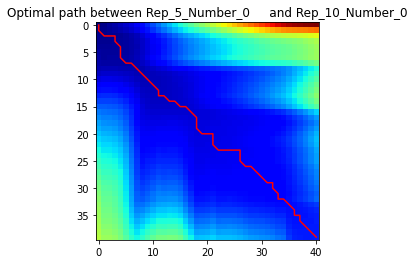

For Rep_5_Number_0, cost of the optimal path: 0.3031290799952406


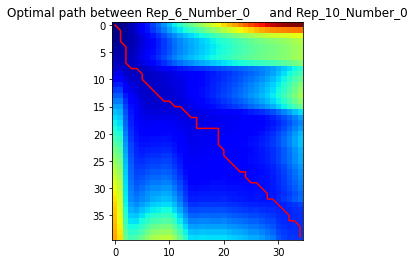

For Rep_6_Number_0, cost of the optimal path: 0.336099212373846


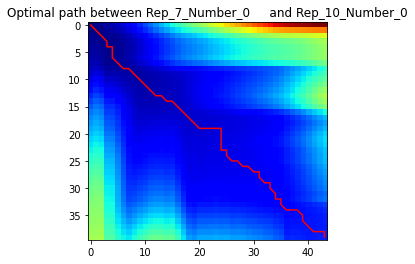

For Rep_7_Number_0, cost of the optimal path: 0.30711677641227325


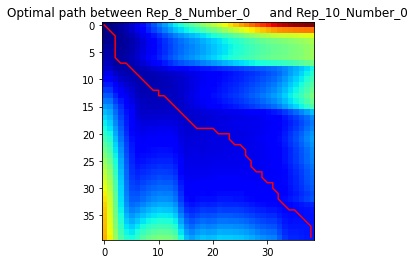

For Rep_8_Number_0, cost of the optimal path: 0.3001524216753318


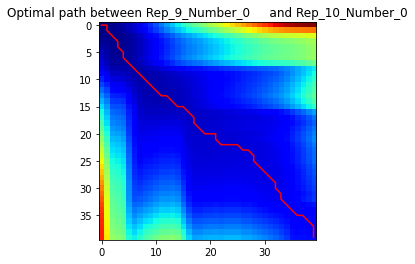

For Rep_9_Number_0, cost of the optimal path: 0.26830793487757
Optimal cost mean 0.3267183828655504


In [480]:
# Align one repetition of the same word with all the other repetitions
print("Ref is " + clean_title(ref))
mean_list =[]
for i, file in enumerate(file_list[::10]):
    sample_rate, wav_data = wavfile.read(path_sig+file)
    cepstral_vectors = feature_extraction(wav_data, window_size,
                                          window_shift, cepstral_order)
    C, M, distance = time_alignment(cepstral_vectors_ref,
                                    cepstral_vectors, gamma=2)
    M = np.array(M)
    plt.imshow(C, cmap='jet')
    plt.title(f"Optimal path between {clean_title(file)} \
    and {clean_title(file_list[0])}")
    plt.plot(M[:,1], M[:,0], color='red')
    plt.show()
    print(f"For {clean_title(file)}, cost of the optimal path:", distance)
    mean_list.append(distance)
print('Optimal cost mean',np.mean(mean_list[1:])) # remove the 0.0 cost of the first rep

Ref is Data DTW/SIG/Rep_10_Number_0


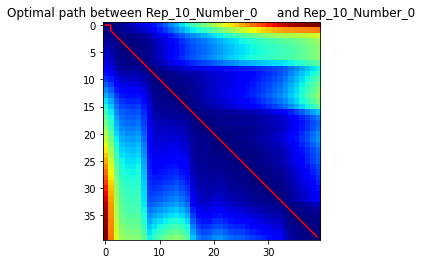

For Rep_10_Number_0, cost of the optimal path: 0.0


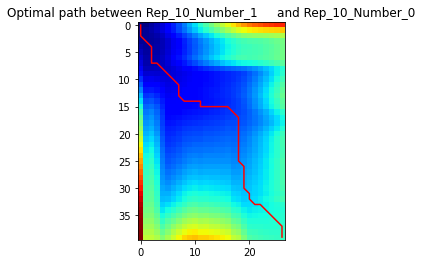

For Rep_10_Number_1, cost of the optimal path: 0.7891160581165133


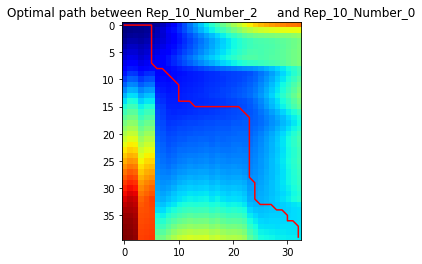

For Rep_10_Number_2, cost of the optimal path: 0.7705094598213837


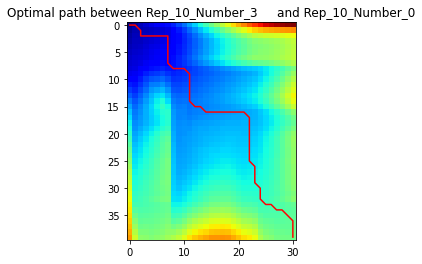

For Rep_10_Number_3, cost of the optimal path: 0.777750593775208


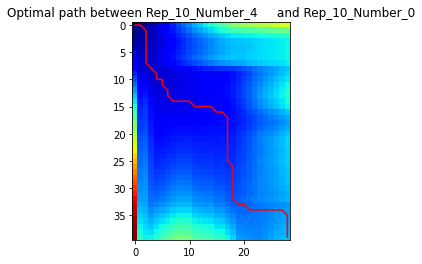

For Rep_10_Number_4, cost of the optimal path: 0.8170624047399099


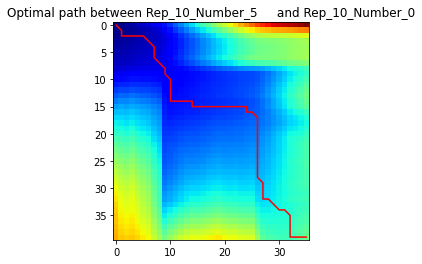

For Rep_10_Number_5, cost of the optimal path: 0.8839545084718192


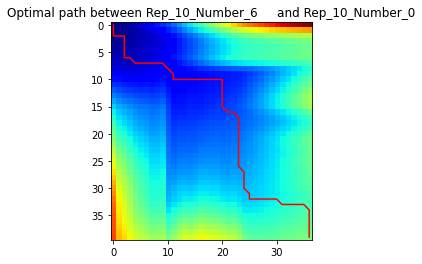

For Rep_10_Number_6, cost of the optimal path: 0.8767275135669779


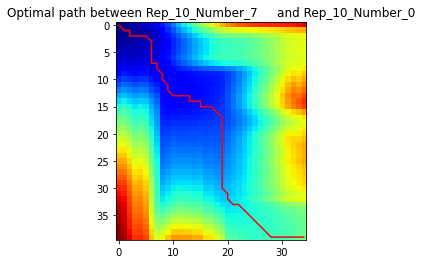

For Rep_10_Number_7, cost of the optimal path: 0.7144501300422118


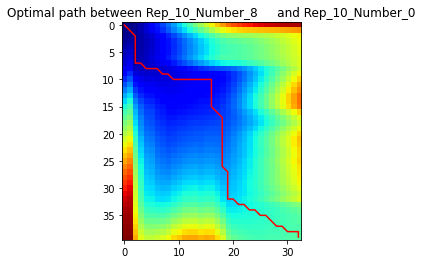

For Rep_10_Number_8, cost of the optimal path: 0.688387841396943


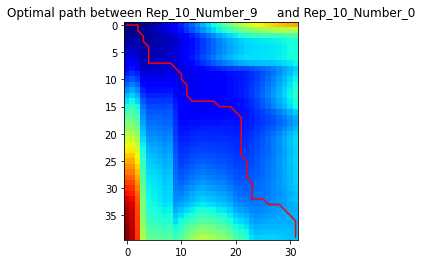

For Rep_10_Number_9, cost of the optimal path: 0.7050649916489338
Optimal cost mean 0.7803359446199889


In [481]:
# Comparison between ref and all numbers from the same rep
print("Ref is " + clean_title(ref))
mean_list = []
for i, file in enumerate(file_list[:10]):
    sample_rate, wav_data = wavfile.read(path_sig+file)
    cepstral_vectors = feature_extraction(wav_data, window_size,
                                          window_shift, cepstral_order)
    C, M, distance = time_alignment(cepstral_vectors_ref,
                                    cepstral_vectors, gamma=2)
    M = np.array(M)
    plt.imshow(C, cmap='jet')
    plt.title(f"Optimal path between {clean_title(file)} \
    and {clean_title(file_list[0])}")
    plt.plot(M[:,1], M[:,0], color='red')
    plt.show()
    print(f"For {clean_title(file)}, cost of the optimal path:", distance)
    mean_list.append(distance)
print('Optimal cost mean',np.mean(mean_list[1:])) 
# to remove the 0.0 cost of the first rep

1. Are the performances satisfactory ?
> We see that the cost of the optimal path is about twice higher when the numbers are not the same. For the number 0, among the 12 different reps, the path is close to the diagonal and the cost is always lower than 0.42, with a mean of 0.32.
> When comparing the 10 numbers from the same rep, the cost is always larger than 0.68 and the mean is 0,78. \
> Those two results show that the algorithm works correctly and could recognize a number in an audio sample.

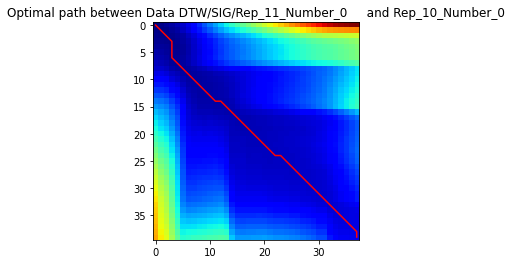

cost of the optimal path: 0.3419902473243609 for gamma = 1


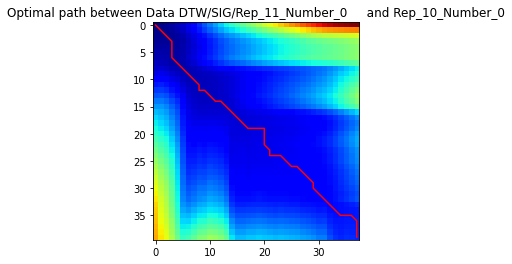

cost of the optimal path: 0.311817940351801 for gamma = 2


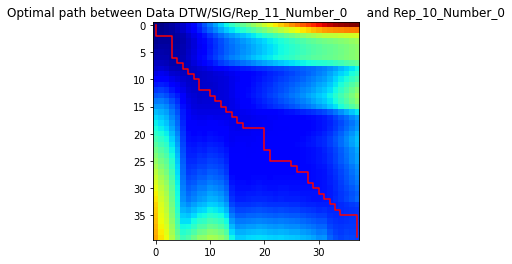

cost of the optimal path: 0.36870923270559663 for gamma = 5


In [482]:
# gamma influence (same number from next rep 0 10th rep and 0 11th rep)
gammas = [1, 2, 5]
for g in gammas:
    file = path_sig + file_list[10] # same number from next rep
    sample_rate, wav_data = wavfile.read(file)
    cepstral_vectors = feature_extraction(wav_data, window_size,
                                          window_shift, cepstral_order)
    C, M, distance = time_alignment(cepstral_vectors_ref,
                                    cepstral_vectors, gamma=g)
    M = np.array(M)
    plt.imshow(C, cmap='jet')
    plt.title(f"Optimal path between {clean_title(file)} \
    and {clean_title(file_list[0])}")
    plt.plot(M[:,1], M[:,0], color='red')
    plt.show()
    print(f"cost of the optimal path:", distance, "for gamma =", g)

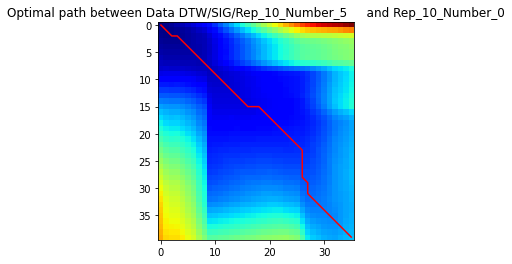

cost of the optimal path: 1.0206975083378214 for gamma = 1


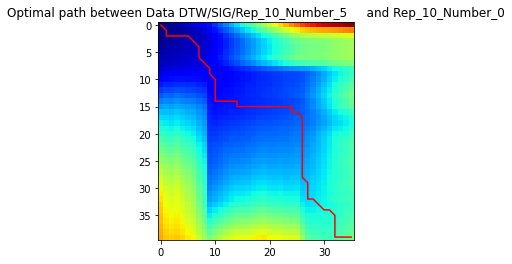

cost of the optimal path: 0.8839545084718192 for gamma = 2


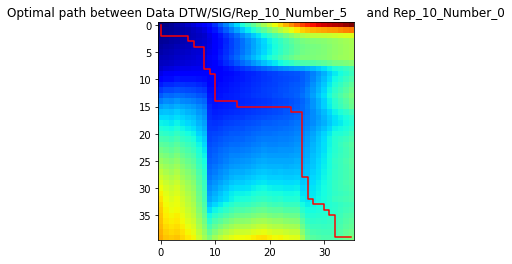

cost of the optimal path: 0.921535532359045 for gamma = 5


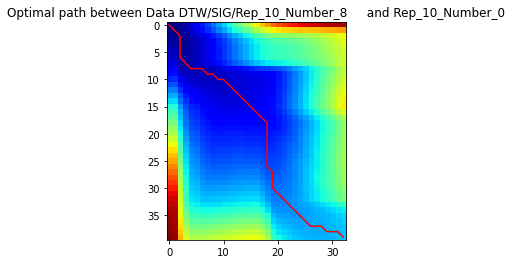

cost of the optimal path: 0.729239819419408 for gamma = 1


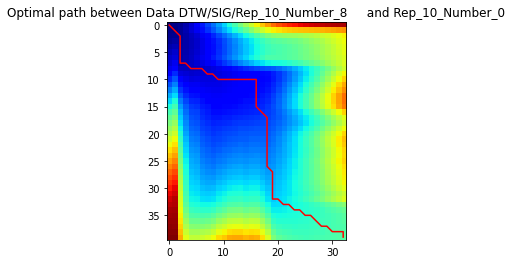

cost of the optimal path: 0.688387841396943 for gamma = 2


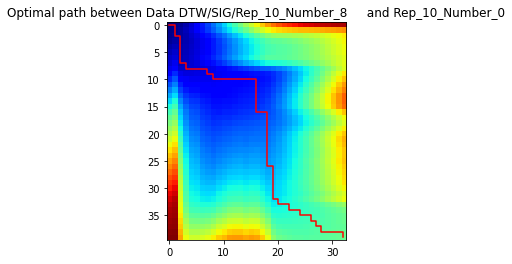

cost of the optimal path: 0.7257999033754327 for gamma = 5


In [484]:
# gamma influence (comparison between 0 and 5, and 8 from 10th rep)
gammas = [1, 2, 5]
for g in gammas:
    file = path_sig + file_list[5] # 10th rep, 0 and 5
    sample_rate, wav_data = wavfile.read(file)
    cepstral_vectors = feature_extraction(wav_data, window_size,
                                          window_shift, cepstral_order)
    C, M, distance = time_alignment(cepstral_vectors_ref,
                                    cepstral_vectors, gamma=g)
    M = np.array(M)
    plt.imshow(C, cmap='jet')
    plt.title(f"Optimal path between {clean_title(file)} \
    and {clean_title(file_list[0])}")
    plt.plot(M[:,1], M[:,0], color='red')
    plt.show()
    print(f"cost of the optimal path:", distance, "for gamma =", g)
for g in gammas:
    file = path_sig + file_list[8] # 10th rep, 0 and 8
    sample_rate, wav_data = wavfile.read(file)
    cepstral_vectors = feature_extraction(wav_data, window_size,
                                          window_shift, cepstral_order)
    C, M, distance = time_alignment(cepstral_vectors_ref,
                                    cepstral_vectors, gamma=g)
    M = np.array(M)
    plt.imshow(C, cmap='jet')
    plt.title(f"Optimal path between {clean_title(file)} \
    and {clean_title(file_list[0])}")
    plt.plot(M[:,1], M[:,0], color='red')
    plt.show()
    print(f"cost of the optimal path:", distance, "for gamma =", g)

2. What is the influence of the γ choice (weighting of the diagonal path) on the alignment paths (in order to answer, examine characteristic cases and try to judge the relevance of the alignment paths by visualizing them) ? Does this parameter have a significant influence on the obtained distance?
>  To analyse the influence of gamma, we had it varying from 1 to 5, taking the value 2 in between. Then we led two different analysis:\
First we looked at the path between two reps of the same number. For a low gamma, the path is close to a diagonal, while for a higher gamma (5), it looks like stairs, and it also remains close to the diagonal. Whatever the value of gamma is, the distance remains similar. It varies in the interval [0.31;0.35], with the lowest value for gamma=2, and the values for extremes gammas (1 and 5) being very close to each other.\
Then, we compared the sounds of different numbers (0, 5 and 8). We chose 5 and 8 because they were the most and the least similar (in terms of distance) to the 0, with gamma = 2 in the previous questions. Again, the results we got show a more diagonal path for lower gammas and a distance that remains close, whatever gamma is. The minimal distance is always reached for gamma = 2.\
We can thus conclude that the influence of gamma is more on the path than on the distance, which is explained by the fact that gamma is taken into account when normalizing the distance. On the one side, gamma = 1 looks to give very diagonal path, that do not always allow to see the difference from two samples. On the other side, gamma = 5 gives paths that look too much like stairs, the high value avoiding to take diagonal steps.\
Hence gamma = 2 seems like a good intermediate value.

What implicit hypothesis is made when using the Euclidean distance to measure the proximity of ceptral vectors? Does this hypothesis seem acceptable to you in view of the differences between aligned sequences corresponding to different repetitions of the same word? Propose (it is not necessary to implement it!) a method to estimate from the aligned data an appropriate weighting for the comparison of ceptral vectors. Do you think this weighting could improve discrimination performance?
>The hypothesis we have made when computing the distance between cepstral vectors with the Euclidean distance is that all 10 components of these vectors are equally important and all represent the same portion of variance of the cepstral vectors. This is actually not the case because of the way we built those vectors, taking the first ten components out of the 256 ones, that were ordered in descending order . In the 10-dimension vector, the first component remains more important than the second one and so on.\
\
> This hypothesis seems acceptable given the results we got. There is a gap in terms of distance when we compare twice the same number and two different number, as we have shown in Questions 1. This gap allows to discriminate between two words. Still, the distance between the same word from two different reps could be smaller, as it is of about 0,3. \
\
>Given some reps of the same word, we could design an algorithm that computes the weights to give to each of the ten components of cepstral vectors in order to reach a lower distance between the samples. The only part that has to be modified is the computation of the distance matrix.

## Evaluation of Speech Recognition

The goal of this part is to implement different cross-validation strategies in order to evaluate how well our method can be used for speech recognition, especially when we generalize to more than one speaker. 
We will separate the available signals into a *reference* and *unknown* set, and label all the unknow signals by finding the signal in the reference set they are the closest to (in terms of cost of the optimal path given by ```time_alignement```. We will then rotate the reference/unknown sets to perform cross-validation. 
To do so, write a function ```evaluation_recognition```.

For example, you can use the following formalism : 

```[confusion, accuracy, D] = evaluation_recognition(vectors, gamma, protocol)```

- ```vectors``` contains all the cepstral vectors for the signals in the database. It can be under the form of a list of matrices, being the outputs of ```feature_extraction``` for all signals. If $N$ if the number of repetetitions, ```vectors``` contains $10N$ matrices.
- ```gamma``` is the parameter $\gamma$ of the alignment.
- ```protocol``` is an integer value between 1 and 3 indicating the protocol to be used: each protocol corresponds to a particular way of dividing signals into training and testing sets. 

- ```confusion``` is the confusion matrix of size $10 \times 10$.
- ```accuracy``` is the recognition rate.
- ```D``` is the distance matrix between each of the elements of the database of size $10N \times 10N$, where $N$ is the number of repetitions. Note that only parts of ```D``` will be used, depending on the protocol choosed. 

The three proposed evaluation protocols are:
- **Protocol 1**: The database is randomly divided in three subsets. Two of these subsets (2/3 of repetitions) are used for the reference set and the remaining subset (1/3 of repetitions) is used for the unknown set. The procedure is repeated by rotating the unknown and reference sets.
- **Protocol 2**: A database containing only one pronunciation of each number is used as a reference database. The remaining repetitions are used for the unkown set. The procedure is repeated by rotating the unkown and reference sets. This protocol aims at evaluating the generalization capabilities of the recognition system. 
- **Protocol 3**: The first half of the database of ```SIG_MIXED``` is used as a reference database and the second half as the unkown database. The procedure is repeated by inversing the role of the two sets. This protocol aims at evaluating the generalization capabilities on a database containing data from the two speakers. Careful: since the goal here is to understand if you can use examples from one person to recognize numbers pronounced by a different person, you have to not shuffle the examples !

In [485]:
window_size = 256
window_shift = 128
cepstral_order = 10
def get_prediction(ref_set, ref_labels, sample, gamma):
    '''
    Compares one sample to the ref set and returns the label of closest
    item from ref set, as prediction for the sample.
    ref_set : list of 2-items lists : label and cepstral vector
    sample : label and cepstral vector of the sample to be predicted
    gamma : gamma factor from time_alignment func
    returns the predicted label of the sample
    '''
    distance = []
    for item in ref_set:
        distance.append(time_alignment(item, sample, gamma)[-1])
    predicted_label = ref_labels[np.argmin(distance)]
    return predicted_label, np.min(distance)

def evaluation_recognition(directory, protocol, gamma=2):
    accuracy_list = []
    confusion = np.zeros((10,10))
    # build vectors matrix and labels from the audio recordings
    files_list = os.listdir(directory)
    if len(files_list) > 100:
        # if more than 10 reps, rep 10, 11, 12, ... are before rep 1
        # so we sort the list
        files_list  = files_list[len(files_list)-90:]+\
        files_list[:len(files_list)-90]
    dataset_size = len(files_list)
    vectors = []
    labels = np.zeros(dataset_size, dtype=int)
    for i, file in enumerate(files_list):
        path = directory + file
        labels[i] = int(file.split('.')[0][-1]) # Extract number from file name
        _ , wav_data = wavfile.read(path)
        cepstral_matrix = np.array(feature_extraction(wav_data, window_size, 
                                              window_shift, cepstral_order))
        vectors.append(cepstral_matrix)
    #vectors is a list of cepstral matrices, that don't all have the same size
    assert len(vectors)==len(files_list), 'vectors matrix not built correctly'
    
    if protocol == 1:
        # ref_set = 2/3 of the total files, with shuffling
        kf = ShuffleSplit(n_splits=3, test_size=1/3)
    elif protocol == 2:
        # ref_set = 10 recordings, each number represented once
        nb_reps = dataset_size//10
        kf = KFold(n_splits=nb_reps)
    elif protocol == 3:
        # to be applied to SIGMIX
        # ref_set is half of the total files, from one speaker
        # while test_set is the other part, from other speaker
        kf = KFold(n_splits=2) 
    else : print('protocol should be an int between 1 and 3')
    
    for ref_idx, test_idx in kf.split(vectors):
        if protocol == 2:
            # for protocol 2, the test set should be all reps but one
            # and the ref set is only one rep so we invert indices given by KF
            ref_idx, test_idx = test_idx, ref_idx
        accuracy = 0
        ref_set = np.asarray(vectors, dtype=object)[ref_idx]
        ref_labels = labels[ref_idx]
        for idx in test_idx:
            label = labels[idx]
            pred, dist = get_prediction(ref_set, ref_labels, vectors[idx], gamma)
            if pred == label:
                accuracy += 1
            confusion[pred, label] +=1
        test_size = test_idx.shape[0]
        accuracy_list.append(accuracy/test_size)
    
    return confusion, np.mean(accuracy_list)

In [486]:
conf, mean_acc = evaluation_recognition(path + 'SIG/', protocol=1, gamma=2)

In [487]:
print('Protocol 1 on SIG')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over the 3-fold cross validation :\n', conf)

Protocol 1 on SIG
Accuracy: 100.00%
Confusion matrix over the 3-fold cross validation :
 [[11.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 14.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 11.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 13.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 13.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 13.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 15.]]


In [488]:
conf, mean_acc = evaluation_recognition(path + 'SIG2/', protocol=1, gamma=2)

In [489]:
print('Protocol 1 on SIG2')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over the 3-fold cross validation :\n', conf)

Protocol 1 on SIG2
Accuracy: 100.00%
Confusion matrix over the 3-fold cross validation :
 [[5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 8. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 7. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 7. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 7.]]


Question:\
Evaluate the speech recognition performance with protocol 1 on the data ```SIG```, and then on the data ```SIG2```. What are the confusions ? What value of $\gamma$ parameter offers the best results ?
> There seems to be little confusion with protocol 1 on both SIG and SIG2 datasets.
Sometimes, 5 and 7 or 6 and 8 are confused but this does not happen in every run.\
This shows that, with a substantial reference dataset, Dynamic Time Warping works well to recognize words.

> The chosen  value of gamma is **two**, which gives very good results with this protocol. We have shown previously that a lower gamma made the optimal path too straight, even when the numbers are different, while the optimal path between the same number from two different recordings looks like stairs with a higher gamma.

In [490]:
conf, mean_acc = evaluation_recognition(path + 'SIG/', protocol=2, gamma=2)

In [491]:
print('Protocol 2 on SIG')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over cross validation :\n', conf)

Protocol 2 on SIG
Accuracy: 97.80%
Confusion matrix over cross validation :
 [[132.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 128.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 124.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 132.   0.   0.   0.   0.   0.   0.]
 [  0.   2.   2.   0. 132.   0.   0.   3.   0.   0.]
 [  0.   2.   0.   0.   0. 130.   0.   6.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 132.   0.   6.   0.]
 [  0.   0.   0.   0.   0.   2.   0. 123.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 126.   0.]
 [  0.   0.   6.   0.   0.   0.   0.   0.   0. 132.]]


In [492]:
conf, mean_acc = evaluation_recognition(path + 'SIG2/', protocol=2, gamma=2)

In [493]:
print('Protocol 2 on SIG2')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over cross validation :\n', conf)

Protocol 2 on SIG2
Accuracy: 99.00%
Confusion matrix over cross validation :
 [[30.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 30.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 30.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 30.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 30.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 30.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 30.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 30.]]


Question : \
Evaluate the generalization capabilities using protocol 2 on the data ```SIG```, and then on the data ```SIG2```. What do you notice?
>We see that DTW seems to generalize quite well. Here, the performance is similar to the one we had with protocol 1 but with a much slower reference set. The same confusions as those from protocol 1 are made here, in a slighly greater proportion.\
Therefore, we can say that, as long as the reference set contains one instance of every word that we want to be able to recognize, the words from the test set will be recognized. It means that the cepstal vectors' variance is more explained by the word that is pronounced (number) than the way it is pronounced (rep). Two different recordings of the same number but from different reps are closer than two different numbers from the same rep, which is the appropriate behavior of the algorithm. Dynamic Time Warping thus has good generalization capabilities since it keeps working well when we reduce the size of the reference set.

In [494]:
conf, mean_acc = evaluation_recognition(path + 'SIGMIX/', protocol=3, gamma=2)

In [495]:
print('Protocol 3')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over cross validation :\n', conf)

Protocol 3
Accuracy: 50.83%
Confusion matrix over cross validation :
 [[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  6.  0.  1.  3.  0.  0.  0.  6.]
 [ 0.  1.  4.  0.  0.  0.  2.  1.  0.  0.]
 [ 2.  0.  0.  8.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  2.  3.  2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  6.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  3. 11.  0.]
 [ 0.  5.  2.  4.  6.  6.  4.  0.  1.  6.]]


**Question:** \
Evaluate the generalization capabilities to other speakers using protocol 3 on ```SIG_MIXED```. Explain the results.
>We observe some important confusions occuring here. This shows that, when the ref set only contains recordings from one speaker, the algorithm is not able to recognize words from other speakers. This may come from the cepstral vectors, thay are likely to be different from one person to another, even when the same word is pronounced.

**Question:** \
What are the limitations of dynamic time warping approaches for speech recognition that you have identified during this lab ? Propose possible solutions to these problems.
>We see that DTW strongly relies on the cepstral vectors of each word to perform speech recognition. For different speakers, as the cepstral vectors for two identical words may be differen, if the algorithm is trained on a reference set from one speaker, we may not be able to recognize words by another speaker. For this first limit, we suggest we could add training elements from all speakers we want to be able to recognize speech. This is what we did in the following function. Pyhton's ```os.listdir()``` returns the file alphabetical order and thus places two-figures reps (like 10, 11 and 12) before others. In the previous function, we modified the lsit of files to make sure that the ```ref_set``` contained only files from one speaker. We won't do that in the following function. As a result, the ```ref_set``` contains reps 10, 11, 12, 1, 2, and 3. The ```test_set``` contains the rest. Hence, the algorithm has reference data from both speakers.

In [497]:
def evaluation_recognition_multi_speaker(directory, protocol, gamma=2):
    accuracy_list = []
    confusion = np.zeros((10,10))
    # build vectors matrix and labels from the audio recordings
    files_list = os.listdir(directory)
    dataset_size = len(files_list)
    vectors = []
    labels = np.zeros(dataset_size, dtype=int)
    for i, file in enumerate(files_list):
        path = directory + file
        labels[i] = int(file.split('.')[0][-1]) # Extract number from file name
        _ , wav_data = wavfile.read(path)
        cepstral_matrix = np.array(feature_extraction(wav_data, window_size, 
                                              window_shift, cepstral_order))
        vectors.append(cepstral_matrix)
    #vectors is a list of cepstral matrices, that don't all have the same size
    assert len(vectors)==len(files_list), 'vectors matrix not built correctly'
    
    if protocol == 1:
        # ref_set = 2/3 of the total files, with shuffling
        kf = ShuffleSplit(n_splits=3, test_size=1/3)
    elif protocol == 2:
        # ref_set = 10 recordings, each number represented once
        nb_reps = dataset_size//10
        kf = KFold(n_splits=nb_reps)
    elif protocol == 3:
        # to be applied to SIGMIX
        # ref_set is half of the total files, from one speaker
        # while test_set is the other part, from other speaker
        kf = KFold(n_splits=2) 
    else : print('protocol should be an int between 1 and 3')
    
    for ref_idx, test_idx in kf.split(vectors):
        if protocol == 2:
            # for protocol 2, the test set should be all reps but one
            # and the ref set is only one rep so we invert indices given by KF
            ref_idx, test_idx = test_idx, ref_idx
        accuracy = 0
        ref_set = np.asarray(vectors, dtype=object)[ref_idx]
        ref_labels = labels[ref_idx]
        for idx in test_idx:
            label = labels[idx]
            pred, dist = get_prediction(ref_set, ref_labels, vectors[idx], gamma)
            if pred == label:
                accuracy += 1
            confusion[pred, label] +=1
        test_size = test_idx.shape[0]
        accuracy_list.append(accuracy/test_size)
    
    return confusion, np.mean(accuracy_list)

In [498]:
conf, mean_acc = evaluation_recognition_multi_speaker(path + 'SIGMIX/', protocol=3, gamma=2)

In [499]:
print('Protocol 3, ref_set with data from both speakers')
print("Accuracy: %.2f%%" % (mean_acc*100))
print('Confusion matrix over cross validation :\n', conf)

Protocol 3, ref_set with data from both speakers
Accuracy: 99.17%
Confusion matrix over cross validation :
 [[12.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 12.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 12.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 12.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 12.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 12.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 12.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 12.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 11.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 12.]]


> We get very satisfying performance by adding data from both speaker in the reference set.\
DTW remains a complicated method, that requires to first isolate cepstal vector of every single word and then compare it to every single word of the database. In order to recognize a full sentence of 10 words in a database of 5,000 words, with maybe 3 different pronunciations for each word of this database, we must compute 150,000 times ```time_alignment()```, which is quite computationally intensive.\
> There may be more advanced techniques used nowadays for speech recognition, such as those relying on Hidden Markov Modeld or benefiting from Neural Networks advances, which is what we saw at the end of the lesson about Speech Recognition. Some of those new models take as input the raw signal, wich is very nice since we are not required anymore to compute features from the signals.